# Elevating Policy-Making
*Lessons from feedback control theory*

Tom Prescott<br>DS Chat 31 May 2024

## Only Reject

- This is a rewrite of a paper I wrote at the Turing
- A proud **desk-reject** 🙅‍♂
- A better audience? Maybe Dom's weirdos.

## Shocks & Resilience

>The pandemic has brought into focus the fact that resilience in one policy area (e.g. health) can come at the cost of resilience in another (e.g. the economy). The overall aim of this large-scale, 2-year research project is to develop a better understanding of resilience in interconnected health, social, and economic systems and to use this understanding to identify robust policy measures.

### "Lessons from Control Theory"

The idea: an extended analogy (with a punning title).
- A public service.
- The *shock*: a pandemic; a Brexit; a step change in inflation.
- The *resilience*: the service quickly rejects the shock.
- How?

### "Lessons from Control Theory"

The idea: an extended analogy (with a punning title).
- A lift.
- The *shock*: someone steps in unexpectedly.
- The *resilience*: the shock is absorbed and quickly rejected.
- How?

# Control

More specifically...

# PID Feedback Control

- Proportional
- Integral
- Derivative

In [1]:
using Pkg
Pkg.activate("../julia/envs/20240531_DS_Chat")
Pkg.add([
        "DifferentialEquations",
        "Plots",
        "ForwardDiff"
    ]
)

  Activating project at `~/code/julia/envs/20240531_DS_Chat`
   Resolving package versions...
  No Changes to `~/code/julia/envs/20240531_DS_Chat/Project.toml`
  No Changes to `~/code/julia/envs/20240531_DS_Chat/Manifest.toml`


In [2]:
using DifferentialEquations
using Plots
using ForwardDiff

In [3]:
struct Person
    weight::Float64
    entry::Float64
    exit::Float64
end
Person(w, t0=0) = Person(w, t0, Inf)

Load = Vector{Person}

weight(p::Person, t::Real) = p.weight * (p.entry <= t <= p.exit)
weight(p::Person, ts) = p.weight .* (p.entry .<= ts .<= p.exit)
weight(l::Load, t) = sum(Base.Fix2(weight, t), l)

(l::Load)(t) = weight(l, t)

In [4]:
struct Lift
    car_weight::Float64
    counter_weight::Float64
end
Lift(car_weight) = Lift(car_weight, car_weight)
weight(l::Lift) = l.car_weight + l.counter_weight

weight (generic function with 4 methods)

In [5]:
function tstops(l::Load)
    ts = mapreduce(p -> [p.entry, p.exit], vcat, l)
    filter!(isfinite, ts)
    filter!(>(0), ts)
    sort!(ts)
    return ts
end

tstops (generic function with 1 method)

In [6]:
struct Reference{T, DT}
    ref::T
    dref::DT
    function Reference(fun::T = t -> 0.0) where T
        dfun = t -> ForwardDiff.derivative(fun, t)
        DT = typeof(dfun)
        return new{T, DT}(fun, dfun)
    end
end

In [7]:
function p_error(r::Reference, trajectory)
    e = function (t)
        r.ref(t) - trajectory(t, dims=0)
    end
    return e
end

function d_error(r::Reference, trajectory)
    e = function (t)
        r.dref(t) - trajectory(t, dims=1)
    end
    return e
end

d_error (generic function with 1 method)

In [8]:
struct PIDGains
    proportional::Float64
    integral::Float64
    derivative::Float64
end

In [9]:
struct ControlledLift{R <: Reference}
    lift::Lift
    load::Load
    ref::R
end
const GRAVITY = 9.81 # m/s

mass(x::ControlledLift, t) = weight(x.lift) + weight(x.load, t)
open_loop_forces(x::ControlledLift, t) = GRAVITY * (x.lift.counter_weight - x.lift.car_weight - weight(x.load, t))

open_loop_forces (generic function with 1 method)

In [10]:
function dynamics(x::ControlledLift)
    _open_loop_forces = Base.Fix1(open_loop_forces, x)
    _mass = Base.Fix1(mass, x)
    _reference = x.ref.ref
    _d_reference = x.ref.dref
    fun = function (du, u, gains, t)
        position = u[1]
        speed = u[2]

        proportional_error = position - _reference(t)
        integral_error = u[3]
        derivative_error = speed - _d_reference(t)

        net_force = _open_loop_forces(t)
        net_force -= get(gains, :proportional, 0) * proportional_error
        net_force -= get(gains, :integral, 0) * integral_error
        net_force -= get(gains, :derivative, 0) * derivative_error

        du[1] = speed
        du[3] = proportional_error
        du[2] = net_force / _mass(t)
        return
    end
    return fun
end

dynamics (generic function with 1 method)

In [29]:
lift = Lift(500)
tom = Person(75, 5, 43)
kate = Person(70, 15, 40)
load = [tom, kate]
ref = Reference(t -> 0.0)
x = ControlledLift(lift, load, ref)

ControlledLift{Reference{var"#89#90", var"#6#8"{var"#89#90"}}}(Lift(500.0, 500.0), Person[Person(75.0, 5.0, 43.0), Person(70.0, 15.0, 40.0)], Reference{var"#89#90", var"#6#8"{var"#89#90"}}(var"#89#90"(), var"#6#8"{var"#89#90"}(var"#89#90"())))

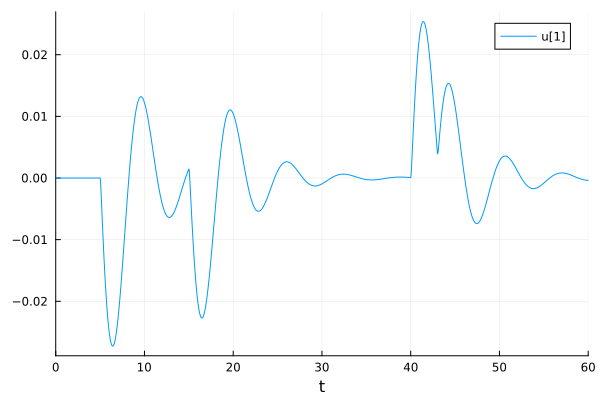

In [30]:
gains = (proportional = 10_000, integral = 20_000, derivative = 20_000)
ode = ODEProblem(dynamics(x), [0, 0, 0], (0.0, 60.0), gains, tstops = tstops(x.load))
sol = solve(ode)
plot(sol, idxs=[1])

In [31]:
function trajectory(
        lift::Lift, 
        load::Load, 
        ref_fun = t -> 0.0, 
        T_final = 60;
        gains...
    )
   
    x = ControlledLift(lift, load, Reference(ref_fun))
    prob = ODEProblem(dynamics(x), [ref_fun(0), 0, 0], (0.0, T_final), NamedTuple(gains))
    sol = solve(prob, tstops = tstops(x.load))
    return sol
end

trajectory (generic function with 3 methods)

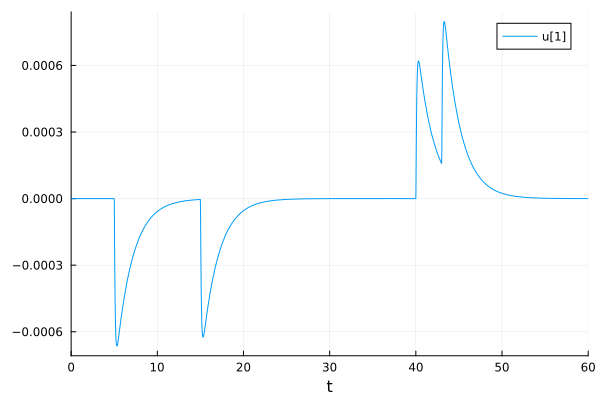

In [32]:
sol = trajectory(
    lift, 
    load, 
    proportional = 1_000_000, 
    derivative = 100_000, 
    integral = 500_000)
plot(sol, idxs = 1)

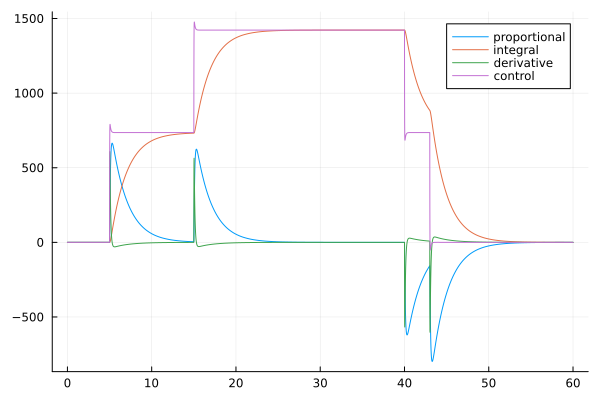

In [34]:
ts = 0:0.01:60
p = t -> -1_000_000 * sol(t, idxs=1)
i = t -> -500_000 * sol(t, idxs=3)
d = t -> -100_000 * sol(t, idxs=2)
c(t) = p(t) + i(t) + d(t)
plot(ts, p, label="proportional")
plot!(ts, i, label="integral")
plot!(ts, d, label="derivative")
plot!(ts, c, label="control") 